In [1]:
import requests

In [2]:
r = requests.get('http://www.citibikenyc.com/stations/json')

In [4]:
#r.json()

In [3]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [3]:
#r.json()['stationBeanList']

In [5]:
key_list = [] #List of keys inside stationBeanList

for keys in r.json()['stationBeanList']:
    for i in keys.keys():
        if i not in key_list:
            key_list.append(i)

In [8]:
key_list

['id',
 'stationName',
 'availableDocks',
 'totalDocks',
 'latitude',
 'longitude',
 'statusValue',
 'statusKey',
 'availableBikes',
 'stAddress1',
 'stAddress2',
 'city',
 'postalCode',
 'location',
 'altitude',
 'testStation',
 'lastCommunicationTime',
 'landMark']

In [9]:
from pandas.io.json import json_normalize
df = json_normalize(r.json()['stationBeanList'])

In [10]:
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,9,29,,72,,2017-04-13 07:54:23 PM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
1,,0,31,,79,,2017-04-13 07:53:52 PM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
2,,0,3,,82,,2017-04-13 12:05:52 PM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,3,Not In Service,False,27
3,,21,40,,83,,2017-04-13 07:55:02 PM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
4,,7,31,,116,,2017-04-13 07:52:26 PM,40.741776,,-74.001497,,W 17 St & 8 Ave,,W 17 St & 8 Ave,1,In Service,False,39


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

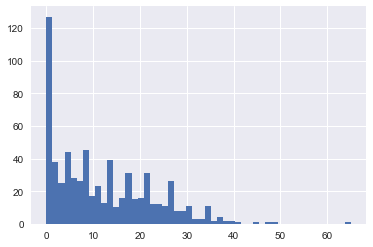

In [18]:
%matplotlib inline
df['availableBikes'].hist(bins=50)

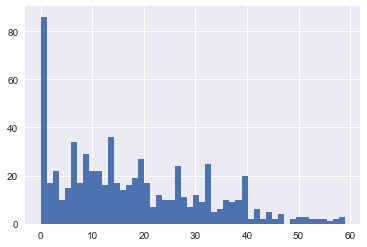

In [33]:
df['availableDocks'].hist(bins=50)

### Stats

In [35]:
condition = (df['statusValue'] == 'In Service')
print ( str(round((float(len(df[condition]['totalDocks'])))/len(df['totalDocks'])*100)) + "% of the docks are in service")

97% of the docks are in service


In [36]:
print ("Mean of available docks - " + str(round(df['availableDocks'].mean(),2)))
print ("Mean of actually available docks - " + str(round(df[condition]['availableDocks'].mean(),2)))

Mean of available docks - 17.67
Mean of actually available docks - 18.21


In [38]:
print ("Mean of available bikes - " + str(round(df['availableBikes'].mean(),2)))
print ("Mean of actually available bikes - " + str(round(df[condition]['availableBikes'].mean(),2)))

Mean of available bikes - 12.01
Mean of actually available bikes - 12.39


31.578783151326054

12.39157566302652

97% of the docks are in service


In [11]:
import sqlite3 as lite

con = lite.connect('citi_bike.db')
cur = con.cursor()

with con:
    cur.execute('DROP TABLE IF EXISTS citibike_reference')
    cur.execute('CREATE TABLE citibike_reference (id INT PRIMARY KEY, totalDocks INT, city TEXT, altitude INT, stAddress2 TEXT, longitude NUMERIC, postalCode TEXT, testStation TEXT, stAddress1 TEXT, stationName TEXT, landMark TEXT, latitude NUMERIC, location TEXT )')

In [12]:
#a prepared SQL statement we're going to execute over and over again
sql = "INSERT INTO citibike_reference (id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)"

#for loop to populate values in the database
with con:
    for station in r.json()['stationBeanList']:
        #id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location)
        cur.execute(sql,(station['id'],station['totalDocks'],station['city'],station['altitude'],station['stAddress2'],station['longitude'],station['postalCode'],station['testStation'],station['stAddress1'],station['stationName'],station['landMark'],station['latitude'],station['location']))

In [14]:
#extract the column from the DataFrame and put them into a list
station_ids = df['id'].tolist() 

#add '_' to the station ids and add INT for SQL script, we're having the code write the SQL query for us
station_ids = ['_' + str(x) + ' INT' for x in station_ids]

#station_ids[1:3]
#Now we execute the query
with con:
    cur.execute("DROP TABLE IF EXISTS available_bikes")
    cur.execute("CREATE TABLE available_bikes ( execution_time INT, " +  ", ".join(station_ids) + ");")

In [15]:
# a package with datetime objects
import time

# a package for parsing a string into a Python datetime object
from dateutil.parser import parse 

import collections


#take the string and parse it into a Python datetime object
exec_time = parse(r.json()['executionTime'])

In [20]:
with con:
    cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)', (exec_time.isoformat(),))

In [21]:
id_bikes = collections.defaultdict(int) #defaultdict to store available bikes by station
id_bikes

defaultdict(int, {})

In [22]:
for station in r.json()['stationBeanList']:
    id_bikes[station['id']] = station['availableBikes']

In [23]:
import datetime
with con:
    for k, v in id_bikes.iteritems():
        cur.execute("UPDATE available_bikes SET _" + str(k) + " = " + str(v) + " WHERE execution_time = " + str((exec_time - datetime.datetime(1970,1,1)).total_seconds()) + ";")

In [24]:
cur.execute("DELETE FROM available_bikes")

In [ ]:
c